In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime
from ncdf_io import ncdf_io
from time_convert import time_convert
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import rcParams,rc
from Lambert_frame_tick import *


In [3]:
dir1='/Users/joedhsu/Research/Rsync/Data_p/GRACE05_JPLmscn/version2_102617/nonCRI/Ocnmass/'
file1='Omass.origrid.m.deg1.com004_175'

mfile1='COASTLINE_MASK.CRIv01'
dir2='/Users/joedhsu/Research/Rsync/Data/JPL_mascon/version2_102617/CRI/netcdf/'
mfile2='LAND_MASK.CRIv01'

## Plotting the mask

/usr/local/lib/python2.7/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


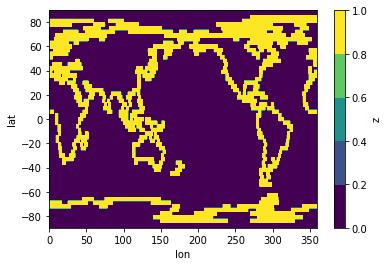

In [4]:
ncfile=ncdf_io(dir1+mfile1+'.nc',verbose=0)
ds_mask1=ncfile.read_ncdf2xarray()
ds_mask1['z'].plot.contourf()

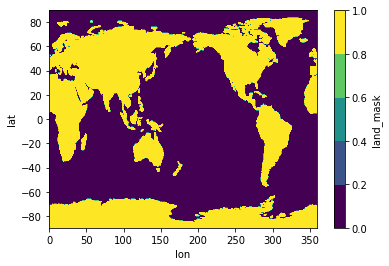

In [5]:
ncfile=ncdf_io(dir2+mfile2+'.nc',verbose=0)
ds_mask2=ncfile.read_ncdf2xarray(dimorder=['lat','lon'])
ds_mask2['land_mask'].plot.contourf()

/usr/local/lib/python2.7/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


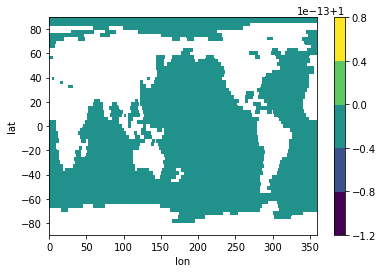

In [6]:
totmask=ds_mask1['z']+ds_mask2['land_mask']
totmask=totmask.where(totmask<1)+1
totmask.plot.contourf()
# totmask.where(totmask<1E-10,1)

## Plotting the JPL mascon solution

/usr/local/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


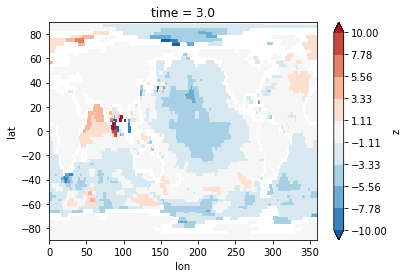

In [7]:
ncfile=ncdf_io(dir1+file1+'.nc',verbose=0)
ds=ncfile.read_ncdf2xarray()
ds['z'].isel(time=0).plot.contourf(levels=np.linspace(-10,10,10))

In [11]:
ds['z']=ds['z']*totmask


## Changing the time stamp

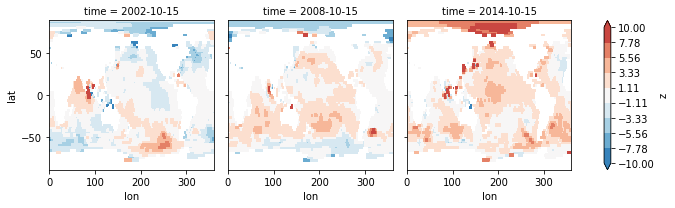

In [12]:
# old time stamp (change from np.array to pd.index)
gmonth=np.array(ds['time'])+1   # start from 0 
tdict=time_convert(gmonth).gmonth2year_mon()
year=tdict['year']
month=tdict['month']
tstamp=pd.to_datetime([datetime.datetime(year[ii],month[ii],15) for ii in range(len(year))])

# assign new time stamp
ds['time']=xr.DataArray(tstamp,coords=[tstamp],dims=['time'])

ds['z'].sel(time=[datetime.datetime(2002,10,15),
                  datetime.datetime(2008,10,15),
                  datetime.datetime(2014,10,15)],method='nearest')\
.plot.contourf(col='time',col_wrap=3,levels=np.linspace(-10,10,10))

## Save data for new mask and time stamp

In [15]:
ds.to_netcdf('./data/jpl_mascon_ocean.nc')
ds_new=xr.open_dataset('./data/jpl_mascon_ocean.nc')    # testing the open_dataset function

In [17]:
ds_new.sel(time=datetime.datetime(2002,10,10),method='nearest')   # testing the time domain selection

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
    time     datetime64[ns] 2002-10-15
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 ...
Data variables:
    z        (lat, lon) float64 ...

## Plotting only the Arctic region

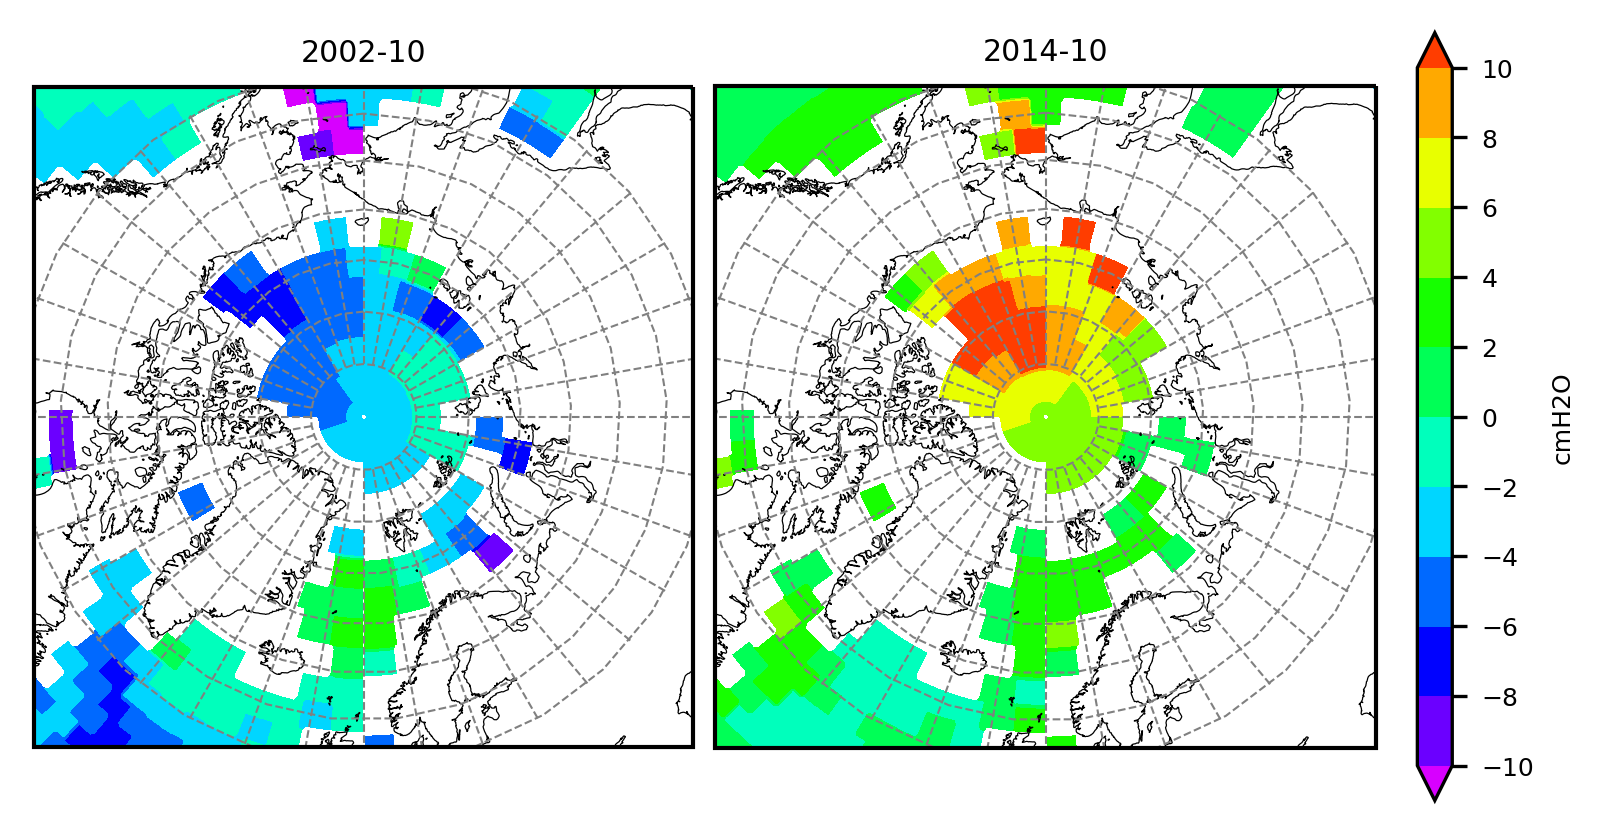

In [23]:
# set the figure and data projection
data_proj=ccrs.PlateCarree()
fig_proj=ccrs.Orthographic(-0, 90)    # rotating the center of the projection
#fig_proj = ccrs.LambertConformal(central_longitude=-50, central_latitude=45)
# fig_proj = ccrs.Mercator(central_longitude=0.0, min_latitude=-80.0, max_latitude=84.0)

# set the figure axes
hmm=70.    # mm
vmm=65.    # mm
fontsize=6
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'
rcParams.update({'font.size': fontsize})
rc('font', family='sans-serif')
rc('font', serif='Helvetica')
mm2inch=0.0393701
hmm=hmm*mm2inch
vmm=vmm*mm2inch
fig=plt.figure(figsize=(hmm,vmm),dpi=300,facecolor='w',edgecolor='w')
ax1=fig.add_axes([0.25,0.07,1.05,0.86],projection=fig_proj)
ax2=fig.add_axes([1.2,0,1,1],projection=fig_proj)

# plot the data in each axes
plot1=ds['z'].sel(time=datetime.datetime(2002,10,15),method='nearest')\
        .plot.contourf(ax=ax1, transform=data_proj
        , levels=np.linspace(-10,10,11), extend='both',cmap='gist_rainbow_r'
        , add_colorbar=False, add_labels=False)
# 'ticks': np.linspace(-10,10,11),'label':'cmH2O'})
ax1.set_title(np.array(ds['z'].sel(time=datetime.datetime(2002,10,15),method='nearest')['time'],dtype='datetime64[M]'))
ax1.set_extent([-180,180,57,90], crs=data_proj)
ax1.coastlines(resolution='50m',linewidth=0.3)

plot2=ds['z'].sel(time=datetime.datetime(2014,10,15),method='nearest').plot.contourf(ax=ax2, transform=data_proj
        , levels=np.linspace(-10,10,11), extend='both',cmap='gist_rainbow_r'
        , cbar_kwargs={'ticks': np.linspace(-10,10,11),'label':'cmH2O'})
ax2.set_title(np.array(ds['z'].sel(time=datetime.datetime(2014,10,15),method='nearest')['time'],dtype='datetime64[M]'))
ax2.set_extent([-180,180,57,90], crs=data_proj)
ax2.coastlines(resolution='50m',linewidth=0.3)

####################  Grid on  ######################
# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xtick=np.linspace(0,360,37)-180.  # need to be -180~180
ytick=np.linspace(55,85,7)

# Label the end-points of the gridlines using the custom tick makers:
ax1.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
# lambert_xticks(ax1, xtick)
# lambert_yticks(ax1, ytick)
ax2.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)

# export the figure
plt.savefig('./figures/arctic_jpl_mascon.pdf', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=None,
        frameon=None)



In [24]:
print np.array(ds['z'].sel(time=datetime.datetime(2002,10,15),method='nearest')['time'],dtype='datetime64[M]')

2002-10


In [25]:
ds['z'].sel(time=datetime.datetime(2002,10,15),method='nearest')['time']

<xarray.DataArray 'time' ()>
array('2002-10-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2002-10-15

## Calculating the trend and seasonality

In [26]:
from regression import regress
from time_convert import time_convert

In [34]:
taxis=time_convert(ds['z'].time+1).tarray_month2year()
reg=regress(taxis)
reg.multivar_regress(ds['z'].isel(lon=0,lat=0).values,predef_var='semisea_sea_lin')
dimname=reg.dm_order

beta=np.zeros([ds['z'].lon.shape[0],ds['z'].lat.shape[0],len(dimname)])+np.nan
se=np.zeros([ds['z'].lon.shape[0],ds['z'].lat.shape[0],len(dimname)])+np.nan 


import time

start = time.time()
ii=0
for i in ds['z'].lon.values :
    jj=0
    for j in ds['z'].lat.values :
        if ~ds['z'].sel(lon=i,lat=j).sum(skipna=False).isnull():
            dict1=reg.multivar_regress(ds['z'].sel(lon=i,lat=j).values,
                                       predef_var='semisea_sea_lin')
            beta[ii,jj]=dict1['beta']
            se[ii,jj]=dict1['se']
        jj+=1
    ii+=1
end = time.time()
print(end - start)

xr_beta=xr.DataArray(beta, coords=[ds['z'].lon,ds['z'].lat,dimname], 
                             dims=['lon','lat','reg_variate'])
xr_se=xr.DataArray(se, coords=[ds['z'].lon,ds['z'].lat,dimname], 
                             dims=['lon','lat','reg_variate'])


ds_beta=xr.Dataset()
ds_beta['beta']=xr_beta.T
ds_beta['se']=xr_se.T



477.14966011


In [176]:
taxis=time_convert(ds['z'].time+1).tarray_month2year()
reg=regress(taxis)
reg.multivar_regress(ds['z'].isel(lon=0,lat=0).values,predef_var='semisea_sea_lin')
dimname=reg.dm_order

beta=np.zeros([ds['z'].lon.shape[0],ds['z'].lat.shape[0],len(dimname)])+np.nan
se=np.zeros([ds['z'].lon.shape[0],ds['z'].lat.shape[0],len(dimname)])+np.nan 

xr_beta=xr.DataArray(beta, coords=[ds['z'].lon,ds['z'].lat,dimname], 
                             dims=['lon','lat','reg_variate'])
xr_se=xr.DataArray(se, coords=[ds['z'].lon,ds['z'].lat,dimname], 
                             dims=['lon','lat','reg_variate'])
start = time.time()
for i in ds['z'].lon :
    for j in ds['z'].lat :
        if ~ds['z'].sel(lon=i,lat=j).sum(skipna=False).isnull():
            dict1=reg.multivar_regress(ds['z'].sel(lon=i,lat=j).values,predef_var='semisea_sea_lin')
            xr_beta.loc[dict(lon=i,lat=j)]=dict1['beta']
            xr_se.loc[dict(lon=i,lat=j)]=dict1['se']
end = time.time()
print(end - start) 

ds_beta=xr.Dataset()
ds_beta['beta']=xr_beta.T
ds_beta['se']=xr_se.T

798.173854113


## Plotting Arctic trend and seasonality

In [220]:
from sinusoidal import feature
annsig=feature()
dict2=annsig.amp_phase(ds_beta['beta'].sel(reg_variate='anncos').values,
                        ds_beta['beta'].sel(reg_variate='annsin').values,
                        np.pi*2.,
                        error=True,
                        ampcos_error = ds_beta['se'].sel(reg_variate='anncos').values,
                        ampsin_error = ds_beta['se'].sel(reg_variate='annsin').values)


# ds_ann=xr.Dataset()
ds_beta['annamp']=xr.DataArray(dict2['amp'], coords=[ds['z'].lat,ds['z'].lon], 
                             dims=['lat','lon'])
ds_beta['annphase']=xr.DataArray(dict2['phase'], coords=[ds['z'].lat,ds['z'].lon], 
                             dims=['lat','lon'])
ds_beta['annamperr']=xr.DataArray(dict2['amperr'], coords=[ds['z'].lat,ds['z'].lon], 
                             dims=['lat','lon'])
ds_beta['annphaseerr']=xr.DataArray(dict2['phaseerr'],coords=[ds['z'].lat,ds['z'].lon], 
                             dims=['lat','lon'])

# xr.concat([ds_beta, ds_ann], dim='reg_variate')

ds_beta.to_netcdf('./data/jpl_mascon_ocean_reg.nc')

sinusoidal.py:83: RuntimeWarning: invalid value encountered in less
  for k in range(time.shape[0]):


In [230]:
from distribution import ci2nstd
ci=ci2nstd()
ci95_st=ci.t_dist(95,reg.dof,ntail=2)
signif=ds_beta['beta'].sel(reg_variate='lin')-ds_beta['se'].sel(reg_variate='lin')*ci95_st
signif_drop=signif.where(signif>0,drop=True)

signif_annamp=ds_beta['annamp']-ds_beta['annamperr']*ci95_st
signif_annamp_drop=signif_annamp.where(signif_annamp>0,drop=True)




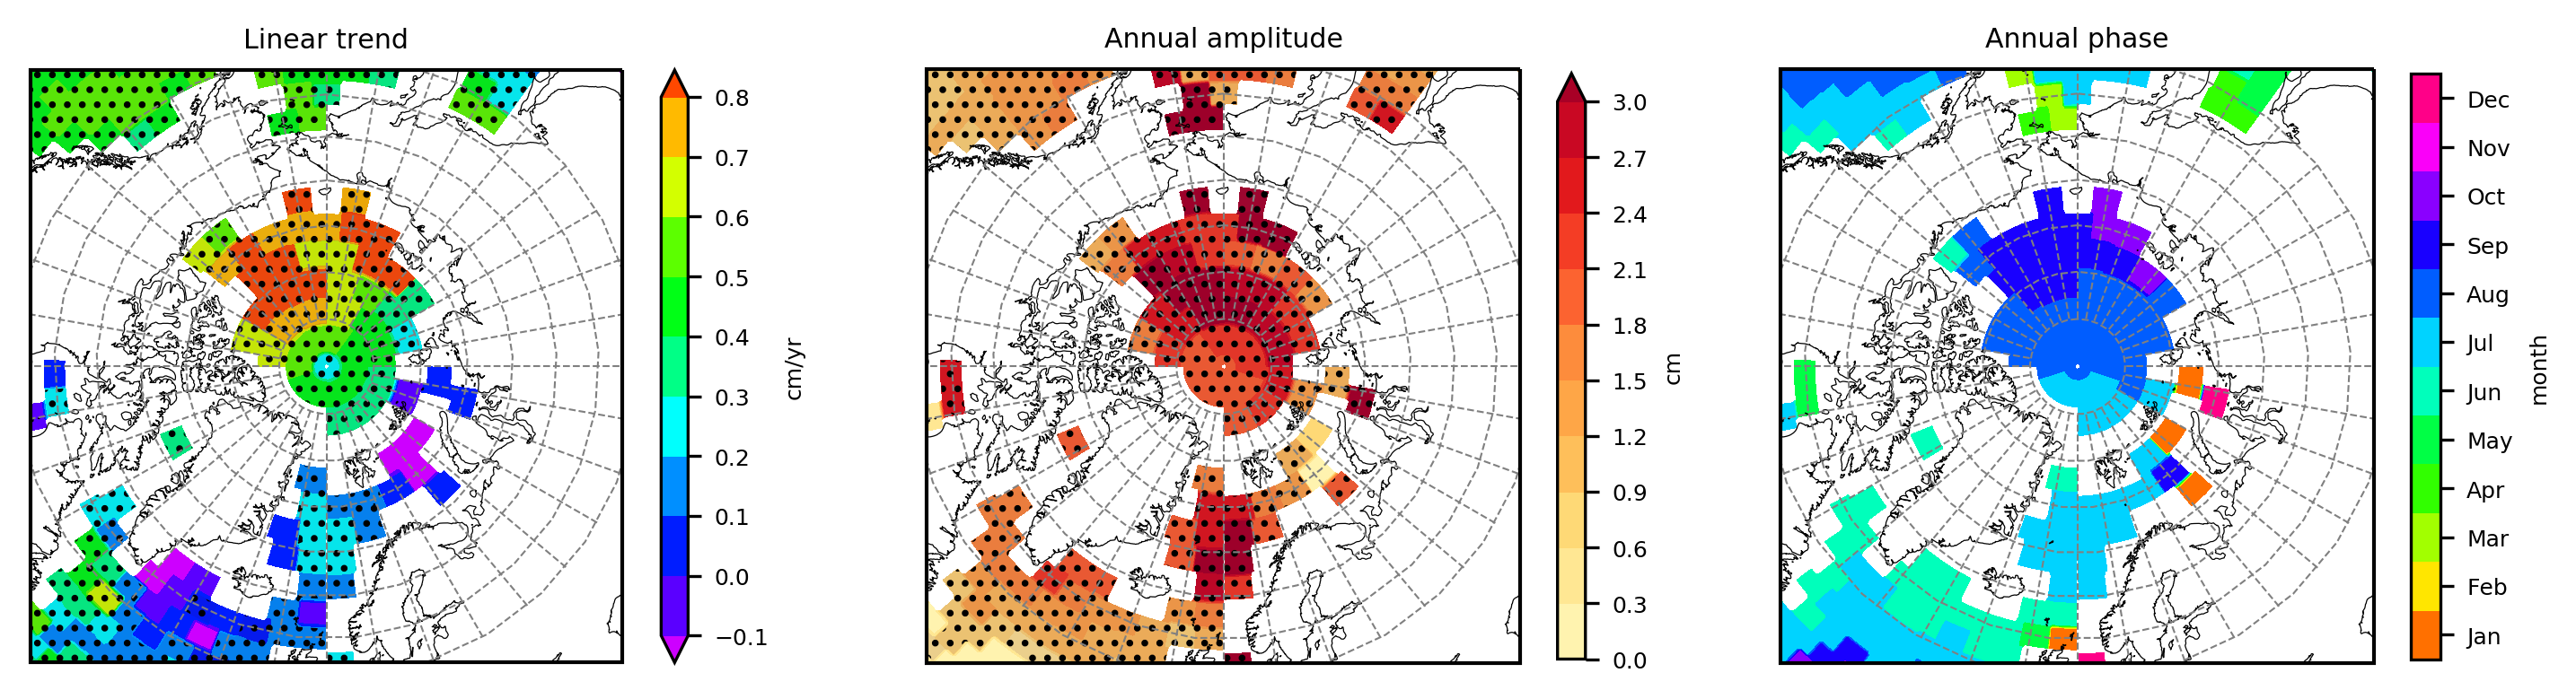

In [252]:
# set the figure and data projection
data_proj=ccrs.PlateCarree()
fig_proj=ccrs.Orthographic(0, 90)    # rotating the center of the projection
#fig_proj = ccrs.LambertConformal(central_longitude=-50, central_latitude=45)
# fig_proj = ccrs.Mercator(central_longitude=0.0, min_latitude=-80.0, max_latitude=84.0)

# set the figure axes
hmm=70.    # mm
vmm=65.    # mm
fontsize=6
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'
rcParams.update({'font.size': fontsize})
rc('font', family='sans-serif')
rc('font', serif='Helvetica')
mm2inch=0.0393701
hmm=hmm*mm2inch
vmm=vmm*mm2inch
fig=plt.figure(figsize=(hmm,vmm),dpi=300,facecolor='w',edgecolor='w')
ax1=fig.add_axes([0.25,0.07,1.05,0.86],projection=fig_proj)
ax2=fig.add_axes([1.5,0,1,1],projection=fig_proj)
ax3=fig.add_axes([1.5*2-0.35,0,1,1],projection=fig_proj)

# plot the data in each axes
levels=np.linspace(-0.1,0.8,10)
plot1=ds_beta['beta'].sel(reg_variate='lin').plot.contourf(ax=ax1, transform=data_proj,
        levels=levels, extend='both',cmap='gist_rainbow_r',
        cbar_kwargs={'ticks': levels,'label':'cm/yr'})
ax1.set_title('Linear trend')
ax1.set_extent([-180,180,57,90], crs=data_proj)
ax1.coastlines(resolution='50m',linewidth=0.3)
signif_drop.plot.contourf(ax=ax1, transform=data_proj, hatches=['...'], alpha=0.1, 
                     add_colorbar=False, add_labels=False)

levels=np.linspace(0,3,11)
plot2=ds_beta['annamp'].plot.contourf(ax=ax2, transform=data_proj
        , levels=levels, extend='max',cmap='YlOrRd'
        , cbar_kwargs={'ticks': levels,'label':'cm','shrink': 0.85})
ax2.set_title('Annual amplitude')
ax2.set_extent([-180,180,57,90], crs=data_proj)
ax2.coastlines(resolution='50m',linewidth=0.3)
signif_annamp_drop.plot.contourf(ax=ax2, transform=data_proj, hatches=['...'], alpha=0.1, 
                     add_colorbar=False, add_labels=False)


levels=np.linspace(0,12,13)
phase=ds_beta['annphase']*12.
plot3=phase.plot.contourf(ax=ax3, transform=data_proj
        , levels=levels, extend='neither',cmap='hsv',add_colorbar=False, add_labels=False)

cbar=plt.colorbar(plot3, shrink=0.85)
cbar.set_ticks(np.linspace(0,11,12)+0.5)
cbar.set_ticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
cbar.set_label('month')

#         , cbar_kwargs={'ticks': np.linspace(0,11,12)+0.5
#                        #,'ticklabels':np.linspace(1,12,12)
#                        ,'label':'phase','shrink': 0.85})
ax3.set_title('Annual phase')
ax3.set_extent([-180,180,57,90], crs=data_proj)
ax3.coastlines(resolution='50m',linewidth=0.3)


####################  Grid on  ######################
# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xtick=np.linspace(0,360,37)-180.  # need to be -180~180
ytick=np.linspace(55,85,7)

# Label the end-points of the gridlines using the custom tick makers:
ax1.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
# lambert_xticks(ax1, xtick)
# lambert_yticks(ax1, ytick)
ax2.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)
ax3.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
ax3.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax3.yaxis.set_major_formatter(LATITUDE_FORMATTER)

# export the figure
plt.savefig('./figures/arctic_jpl_mascon_reg.pdf', dpi=500, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=None,
        frameon=None)


#### Comparing the old phase function with the new feature class

In [162]:
from sinusoidal import annual_phase, feature
dict1=annual_phase(ds_beta['beta'].sel(reg_variate='anncos').values,
             ds_beta['beta'].sel(reg_variate='annsin').values,
             ampcos_error = ds_beta['se'].sel(reg_variate='anncos').values,
             ampsin_error = ds_beta['se'].sel(reg_variate='annsin').values)

annsig=feature()
dict2=annsig.amp_phase(ds_beta['beta'].sel(reg_variate='anncos').values,
                        ds_beta['beta'].sel(reg_variate='annsin').values,
                        np.pi*2.,
                        error=True,
                        ampcos_error = ds_beta['se'].sel(reg_variate='anncos').values,
                        ampsin_error = ds_beta['se'].sel(reg_variate='annsin').values)

sinusoidal.py:82: RuntimeWarning: invalid value encountered in less
  # calculate the annual signal


###### Phase error estimate

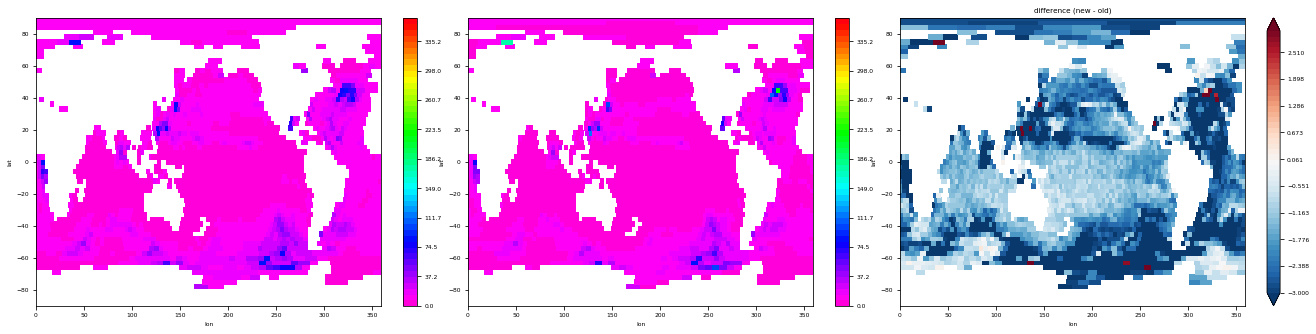

In [174]:
fig=plt.figure()
ax1=fig.add_axes([0,0,1,1])
ax2=fig.add_axes([1,0,1,1])
ax3=fig.add_axes([2,0,1,1])

xr_phase1=xr.DataArray(dict1['phase error'], coords=[ds['z'].lat,ds['z'].lon], dims=['lat','lon'])*totmask
xr_phase1.plot(ax=ax1,cmap='gist_rainbow_r',levels=np.linspace(0,365))

xr_phase2=xr.DataArray(dict2['phaseerr']*365., coords=[ds['z'].lat,ds['z'].lon], dims=['lat','lon'])*totmask
xr_phase2.plot(ax=ax2,cmap='gist_rainbow_r',levels=np.linspace(0,365))

xr_phase3=xr.DataArray(dict2['phaseerr']*365.-dict1['phase error'], coords=[ds['z'].lat,ds['z'].lon], dims=['lat','lon'])*totmask
xr_phase3.plot(ax=ax3,levels=np.linspace(-3,3))
ax3.set_title('difference (new - old)')


###### Phase estimate

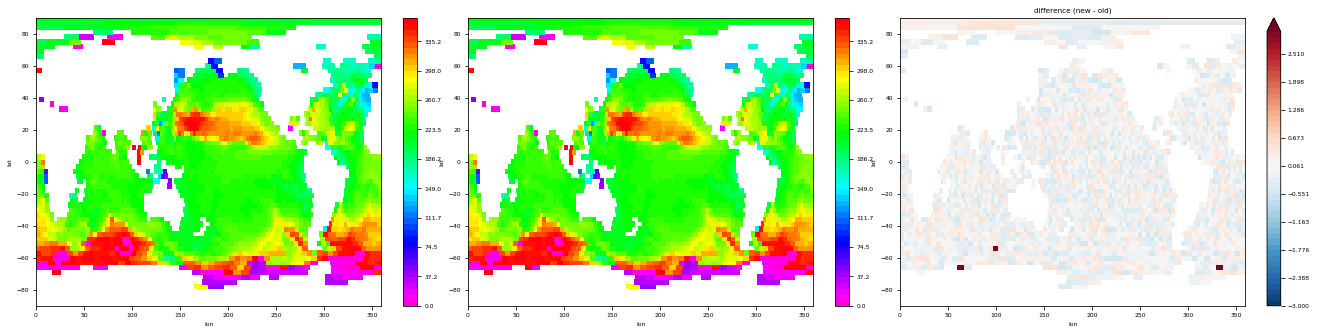

In [175]:
fig=plt.figure()
ax1=fig.add_axes([0,0,1,1])
ax2=fig.add_axes([1,0,1,1])
ax3=fig.add_axes([2,0,1,1])

xr_phase1=xr.DataArray(dict1['phase'], coords=[ds['z'].lat,ds['z'].lon], dims=['lat','lon'])*totmask
xr_phase1.plot(ax=ax1,cmap='gist_rainbow_r',levels=np.linspace(0,365))

xr_phase2=xr.DataArray(dict2['phase']*365., coords=[ds['z'].lat,ds['z'].lon], dims=['lat','lon'])*totmask
xr_phase2.plot(ax=ax2,cmap='gist_rainbow_r',levels=np.linspace(0,365))

xr_phase3=xr.DataArray(dict2['phase']*365.-dict1['phase'], coords=[ds['z'].lat,ds['z'].lon], dims=['lat','lon'])*totmask
xr_phase3.plot(ax=ax3,levels=np.linspace(-3,3))
ax3.set_title('difference (new - old)')